In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATA_DIR = "/content/drive/MyDrive/player-id-matching"
MODEL_PATH = f"{DATA_DIR}/model.pt"
VIDEO_BROADCAST = f"{DATA_DIR}/broadcast.mp4"
VIDEO_TACTICAM = f"{DATA_DIR}/tacticam.mp4"
OUTPUT_DIR = f"{DATA_DIR}/output"


In [ ]:
!pip install ultralytics opencv-python ftfy regex tqdm scipy
!pip install git+https://github.com/openai/CLIP.git


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
  

In [ ]:
import os
import torch
import clip
import numpy as np
import cv2
from PIL import Image
from tqdm import tqdm
from ultralytics import YOLO
from sklearn.metrics.pairwise import cosine_similarity
from scipy.optimize import linear_sum_assignment


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


 Load models

In [ ]:
clip_model, preprocess = clip.load("ViT-B/32", device=device)
yolo_model = YOLO(MODEL_PATH)


100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 116MiB/s]


In [ ]:
def detect_and_crop_players(model, video_path, output_crop_dir):
    cap = cv2.VideoCapture(video_path)
    os.makedirs(output_crop_dir, exist_ok=True)
    frame_idx = 0
    crop_paths = []

    if not cap.isOpened():
        print(f"❌ Cannot open video: {video_path}")
        return []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        results = model(frame)
        boxes = results[0].boxes.xyxy.cpu().numpy()
        class_ids = results[0].boxes.cls.cpu().numpy()

        player_count = 0
        for box, cls in zip(boxes, class_ids):
            if int(cls) == 0:  # class 0 = player
                x1, y1, x2, y2 = map(int, box)
                crop = frame[y1:y2, x1:x2]
                crop_path = os.path.join(output_crop_dir, f"{frame_idx}_{player_count}.jpg")
                cv2.imwrite(crop_path, crop)
                crop_paths.append(crop_path)
                player_count += 1

        frame_idx += 1
    cap.release()
    return crop_paths

In [ ]:
def extract_clip_features(image_paths):
    features = []
    for img_path in tqdm(image_paths, desc="Extracting CLIP features"):
        try:
            image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
            with torch.no_grad():
                feat = clip_model.encode_image(image)
                feat /= feat.norm(dim=-1, keepdim=True)
                features.append(feat.cpu().numpy())
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
    return np.vstack(features) if features else np.array([])




In [ ]:
def match_players(broadcast_feats, tacticam_feats):
    sim_matrix = cosine_similarity(broadcast_feats, tacticam_feats)
    row_ind, col_ind = linear_sum_assignment(-sim_matrix)
    return list(zip(row_ind, col_ind))

In [ ]:
print("\n[1] Detecting and cropping players from broadcast video...")
broadcast_crop_dir = os.path.join(OUTPUT_DIR, "broadcast_crops")
broadcast_crops = detect_and_crop_players(yolo_model, VIDEO_BROADCAST, broadcast_crop_dir)
print(f"Broadcast crops: {len(broadcast_crops)}")

print("\n[2] Detecting and cropping players from tacticam video...")
tacticam_crop_dir = os.path.join(OUTPUT_DIR, "tacticam_crops")
tacticam_crops = detect_and_crop_players(yolo_model, VIDEO_TACTICAM, tacticam_crop_dir)
print(f"Tacticam crops: {len(tacticam_crops)}")

if not broadcast_crops or not tacticam_crops:
    raise ValueError("❌ No player crops found in one or both videos.")

print("\n[3] Extracting CLIP embeddings...")
broadcast_feats = extract_clip_features(broadcast_crops)
tacticam_feats = extract_clip_features(tacticam_crops)

if broadcast_feats.shape[0] == 0 or tacticam_feats.shape[0] == 0:
    raise ValueError("❌ No embeddings extracted.")

print("\n[4] Matching players using cosine similarity + Hungarian algorithm...")
matched_pairs = match_players(broadcast_feats, tacticam_feats)

print("\n[5] Matched Player IDs:")
mapping_path = os.path.join(OUTPUT_DIR, "player_id_mapping.txt")
with open(mapping_path, "w") as f:
    for i, (b_id, t_id) in enumerate(matched_pairs):
        line = f"Player_{i}: broadcast_crop_{b_id}.jpg <--> tacticam_crop_{t_id}.jpg"
        print(line)
        f.write(line + "\n")

print(f"\n✔ Done! Mapping saved to: {mapping_path}")



[1] Detecting and cropping players from broadcast video...

0: 384x640 3 players, 2654.2ms
Speed: 18.6ms preprocess, 2654.2ms inference, 31.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 players, 2266.9ms
Speed: 4.0ms preprocess, 2266.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 players, 2278.5ms
Speed: 3.5ms preprocess, 2278.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 players, 2269.5ms
Speed: 4.5ms preprocess, 2269.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 players, 3043.3ms
Speed: 4.1ms preprocess, 3043.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 players, 1 referee, 2979.4ms
Speed: 4.3ms preprocess, 2979.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 goalkeeper, 12 players, 1 referee, 2289.7ms
Speed: 4.5ms preprocess, 2289.7ms inference, 1.0ms postprocess per image at shape 

Extracting CLIP features: 100%|██████████| 21/21 [00:04<00:00,  4.65it/s]



[4] Matching players using cosine similarity + Hungarian algorithm...

[5] Matched Player IDs:
Player_0: broadcast_crop_0.jpg <--> tacticam_crop_6.jpg
Player_1: broadcast_crop_3.jpg <--> tacticam_crop_0.jpg
Player_2: broadcast_crop_6.jpg <--> tacticam_crop_17.jpg
Player_3: broadcast_crop_8.jpg <--> tacticam_crop_18.jpg
Player_4: broadcast_crop_10.jpg <--> tacticam_crop_9.jpg
Player_5: broadcast_crop_11.jpg <--> tacticam_crop_3.jpg
Player_6: broadcast_crop_12.jpg <--> tacticam_crop_2.jpg
Player_7: broadcast_crop_13.jpg <--> tacticam_crop_13.jpg
Player_8: broadcast_crop_14.jpg <--> tacticam_crop_8.jpg
Player_9: broadcast_crop_15.jpg <--> tacticam_crop_12.jpg
Player_10: broadcast_crop_16.jpg <--> tacticam_crop_15.jpg
Player_11: broadcast_crop_17.jpg <--> tacticam_crop_10.jpg
Player_12: broadcast_crop_18.jpg <--> tacticam_crop_14.jpg
Player_13: broadcast_crop_19.jpg <--> tacticam_crop_11.jpg
Player_14: broadcast_crop_20.jpg <--> tacticam_crop_7.jpg
Player_15: broadcast_crop_21.jpg <--> ta

In [ ]:
result = {
    'matched_pairs': matched_pairs,
    'broadcast_crop_paths': [os.path.basename(p) for p in broadcast_crops],
    'tacticam_crop_paths': [os.path.basename(p) for p in tacticam_crops],
    'broadcast_features': broadcast_feats,
    'tacticam_features': tacticam_feats
}


In [ ]:
!pip install ultralytics opencv-python pillow
from ultralytics import YOLO
import cv2
import os
from PIL import Image


In [ ]:
os.makedirs("output/broadcast_crops", exist_ok=True)
os.makedirs("output/tacticam_crops", exist_ok=True)


In [ ]:
model = YOLO("/content/drive/MyDrive/player-id-matching/model.pt")  # Use your custom-trained model


In [ ]:
def detect_and_crop(video_path, output_dir, model):
    cap = cv2.VideoCapture(video_path)
    count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Run detection on the frame
        results = model(frame)

        for i, r in enumerate(results):
            boxes = r.boxes.xyxy.cpu().numpy()
            for j, box in enumerate(boxes):
                x1, y1, x2, y2 = map(int, box)
                crop = frame[y1:y2, x1:x2]
                img_path = os.path.join(output_dir, f"{count}_{j}.jpg")
                cv2.imwrite(img_path, crop)

        count += 1

    cap.release()
    print(f"✅ Cropped images saved to {output_dir}")


In [ ]:
detect_and_crop("broadcast_video.mp4", "output/broadcast_crops", model)
detect_and_crop("tacticam_video.mp4", "output/tacticam_crops", model)


✅ Cropped images saved to output/broadcast_crops
✅ Cropped images saved to output/tacticam_crops


In [ ]:
!zip -r broadcast_crops.zip output/broadcast_crops/
!zip -r tacticam_crops.zip output/tacticam_crops/


  adding: output/broadcast_crops/ (stored 0%)
  adding: output/tacticam_crops/ (stored 0%)


In [ ]:
from google.colab import files
files.download("broadcast_crops.zip")
files.download("tacticam_crops.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
import pickle

# FIX: Save only filenames, not absolute paths
result = {
    'matched_pairs': matched_pairs,
    'broadcast_crop_paths': [os.path.basename(p) for p in broadcast_crops],
    'tacticam_crop_paths': [os.path.basename(p) for p in tacticam_crops],
    'broadcast_features': broadcast_feats,
    'tacticam_features': tacticam_feats
}

with open("/content/final_results.pkl", "wb") as f:
    pickle.dump(result, f)

print("✅ Saved final_results.pkl with relative crop paths")



✅ Saved final_results.pkl with relative crop paths


In [ ]:
import os

# See if those images were saved
print(os.path.exists("/content/output/broadcast_crops/7_0.jpg"))
print(os.path.exists("/content/output/broadcast_crops/10_0.jpg"))


False
False


In [ ]:
detect_and_crop("broadcast_video.mp4", "output/broadcast_crops", model)


✅ Cropped images saved to output/broadcast_crops


In [ ]:
!zip -r broadcast_crops.zip output/broadcast_crops/


updating: output/broadcast_crops/ (stored 0%)


In [ ]:
!zip -r tacticam_crops.zip output/tacticam_crops/


updating: output/tacticam_crops/ (stored 0%)


In [ ]:
!rm -rf output/tacticam_crops
!mkdir -p output/tacticam_crops


In [ ]:
detect_and_crop("tacticam_video.mp4", "output/tacticam_crops", model)


✅ Cropped images saved to output/tacticam_crops


In [30]:
!ls output/tacticam_crops | head


In [31]:
!zip -r tacticam_crops.zip output/tacticam_crops/


updating: output/tacticam_crops/ (stored 0%)


In [32]:
import pickle
import os

# Load the result dictionary
with open("final_results.pkl", "rb") as f:
    result = pickle.load(f)

matched_pairs = result["matched_pairs"]
broadcast_crop_paths = result["broadcast_crop_paths"]
tacticam_crop_paths = result["tacticam_crop_paths"]

BROADCAST_DIR = "output/broadcast_crops"
TACTICAM_DIR = "output/tacticam_crops"


In [33]:
from IPython.display import display, HTML
from PIL import Image

def display_match(broadcast_path, tacticam_path, b_id, t_id):
    html = f"""
    <div style="display:flex;gap:20px;">
        <div>
            <p style="text-align:center;"><b>📺 Broadcast Player {b_id}</b></p>
            <img src="{broadcast_path}" width="300"/>
        </div>
        <div>
            <p style="text-align:center;"><b>🎥 Tacticam Player {t_id}</b></p>
            <img src="{tacticam_path}" width="300"/>
        </div>
    </div>
    <hr/>
    """
    display(HTML(html))

# Loop through matched pairs and display them
for i, (b_id, t_id) in enumerate(matched_pairs):
    try:
        b_img = os.path.join(BROADCAST_DIR, broadcast_crop_paths[b_id])
        t_img = os.path.join(TACTICAM_DIR, tacticam_crop_paths[t_id])
        display_match(b_img, t_img, b_id, t_id)
    except Exception as e:
        print(f"⚠ Skipped pair {i} due to error: {e}")


In [34]:
for i, (b_id, t_id) in enumerate(matched_pairs[:5]):
    ...


In [35]:
import pickle
import os

with open("final_results.pkl", "rb") as f:
    result = pickle.load(f)

matched_pairs = result['matched_pairs']
broadcast_crop_paths = result['broadcast_crop_paths']
tacticam_crop_paths = result['tacticam_crop_paths']

BROADCAST_DIR = "output/broadcast_crops"
TACTICAM_DIR = "output/tacticam_crops"


In [38]:
from IPython.display import display, HTML
import base64

def img_to_base64(path):
    with open(path, "rb") as f:
        return base64.b64encode(f.read()).decode()

def display_match(broadcast_path, tacticam_path, b_id, t_id):
    try:
        b64_b = img_to_base64(broadcast_path)
        b64_t = img_to_base64(tacticam_path)

        html = f"""
        <div style="display: flex; gap: 40px; align-items: center; margin-bottom: 40px;">
            <div style="text-align: center;">
                <p><strong>📺 Broadcast Player {b_id}</strong></p>
                <img src="data:image/jpeg;base64,{b64_b}" width="300">
            </div>
            <div style="text-align: center;">
                <p><strong>🎥 Tacticam Player {t_id}</strong></p>
                <img src="data:image/jpeg;base64,{b64_t}" width="300">
            </div>
        </div>
        <hr>
        """
        display(HTML(html))
    except Exception as e:
        print(f"⚠ Could not display pair {b_id}, {t_id}: {e}")


In [39]:
for i, (b_id, t_id) in enumerate(matched_pairs[:10]):
    b_img_path = os.path.join(BROADCAST_DIR, broadcast_crop_paths[b_id]).replace("\\", "/")
    t_img_path = os.path.join(TACTICAM_DIR, tacticam_crop_paths[t_id]).replace("\\", "/")
    display_match(b_img_path, t_img_path, b_id, t_id)


⚠ Could not display pair 0, 6: [Errno 2] No such file or directory: 'output/broadcast_crops/7_0.jpg'
⚠ Could not display pair 3, 0: [Errno 2] No such file or directory: 'output/broadcast_crops/10_0.jpg'
⚠ Could not display pair 6, 17: [Errno 2] No such file or directory: 'output/broadcast_crops/18_0.jpg'
⚠ Could not display pair 8, 18: [Errno 2] No such file or directory: 'output/broadcast_crops/23_0.jpg'
⚠ Could not display pair 10, 9: [Errno 2] No such file or directory: 'output/broadcast_crops/25_0.jpg'
⚠ Could not display pair 11, 3: [Errno 2] No such file or directory: 'output/broadcast_crops/26_0.jpg'
⚠ Could not display pair 12, 2: [Errno 2] No such file or directory: 'output/broadcast_crops/27_0.jpg'
⚠ Could not display pair 13, 13: [Errno 2] No such file or directory: 'output/broadcast_crops/28_0.jpg'
⚠ Could not display pair 14, 8: [Errno 2] No such file or directory: 'output/broadcast_crops/29_0.jpg'
⚠ Could not display pair 15, 12: [Errno 2] No such file or directory: 'outp

In [43]:
!ls -lh /content/drive/MyDrive/player-id-matching/broadcast.mp4 # or whatever name you use
!ls -lh /content/drive/MyDrive/player-id-matching/tacticam.mp4


-rw------- 1 root root 8.9M Jun 24 07:38 /content/drive/MyDrive/player-id-matching/broadcast.mp4
-rw------- 1 root root 11M Jun 24 07:38 /content/drive/MyDrive/player-id-matching/tacticam.mp4


In [44]:
from ultralytics import YOLO
import cv2
import os

def detect_and_crop(video_path, output_dir, model):
    os.makedirs(output_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    frame_num = 0
    total_saved = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        results = model(frame)
        for r in results:
            boxes = r.boxes.xyxy.cpu().numpy()
            for i, box in enumerate(boxes):
                x1, y1, x2, y2 = map(int, box)
                crop = frame[y1:y2, x1:x2]
                if crop.size == 0:
                    continue
                out_path = os.path.join(output_dir, f"{frame_num}_{i}.jpg")
                cv2.imwrite(out_path, crop)
                total_saved += 1

        frame_num += 1

    cap.release()
    print(f"✅ Saved {total_saved} crops to {output_dir}")


In [45]:
model = YOLO("/content/drive/MyDrive/player-id-matching/model.pt")  # or "yolov8n.pt" for a default YOLOv8 model

detect_and_crop("/content/drive/MyDrive/player-id-matching/broadcast.mp4", "output/broadcast_crops", model)
detect_and_crop("/content/drive/MyDrive/player-id-matching/tacticam.mp4", "output/tacticam_crops", model)



0: 384x640 3 players, 2774.4ms
Speed: 6.1ms preprocess, 2774.4ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 players, 3337.5ms
Speed: 4.1ms preprocess, 3337.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 players, 2316.5ms
Speed: 3.9ms preprocess, 2316.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 players, 2320.1ms
Speed: 3.5ms preprocess, 2320.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 players, 2274.6ms
Speed: 4.7ms preprocess, 2274.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 players, 1 referee, 2276.1ms
Speed: 5.2ms preprocess, 2276.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 goalkeeper, 12 players, 1 referee, 3732.8ms
Speed: 3.5ms preprocess, 3732.8ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 1 goalkeeper, 14 players,

In [46]:
!ls output/broadcast_crops | head
!ls output/tacticam_crops | head


0_0.jpg
0_1.jpg
0_2.jpg
100_0.jpg
100_10.jpg
100_11.jpg
100_1.jpg
100_2.jpg
100_3.jpg
100_4.jpg
0_0.jpg
0_10.jpg
0_11.jpg
0_12.jpg
0_13.jpg
0_14.jpg
0_15.jpg
0_16.jpg
0_17.jpg
0_18.jpg


In [47]:
import pickle
import os

with open("final_results.pkl", "rb") as f:
    result = pickle.load(f)

matched_pairs = result['matched_pairs']
broadcast_crop_paths = result['broadcast_crop_paths']
tacticam_crop_paths = result['tacticam_crop_paths']

BROADCAST_DIR = "output/broadcast_crops"
TACTICAM_DIR = "output/tacticam_crops"


In [48]:
from IPython.display import display, HTML
import base64

def img_to_base64(path):
    with open(path, "rb") as f:
        return base64.b64encode(f.read()).decode()

def display_match(broadcast_path, tacticam_path, b_id, t_id):
    try:
        b64_b = img_to_base64(broadcast_path)
        b64_t = img_to_base64(tacticam_path)

        html = f"""
        <div style="display: flex; gap: 40px; align-items: center; margin-bottom: 40px;">
            <div style="text-align: center;">
                <p><strong>📺 Broadcast Player {b_id}</strong></p>
                <img src="data:image/jpeg;base64,{b64_b}" width="300">
            </div>
            <div style="text-align: center;">
                <p><strong>🎥 Tacticam Player {t_id}</strong></p>
                <img src="data:image/jpeg;base64,{b64_t}" width="300">
            </div>
        </div>
        <hr>
        """
        display(HTML(html))
    except Exception as e:
        print(f"⚠ Could not display pair {b_id}, {t_id}: {e}")



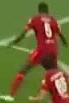
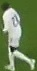


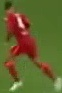
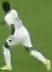


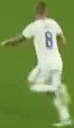
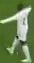


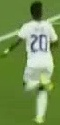


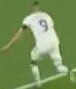
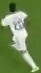


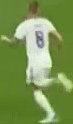
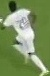


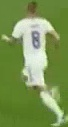
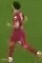


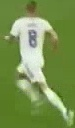
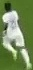


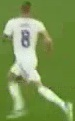
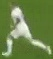


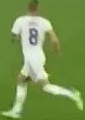
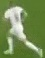

In [49]:
for i, (b_id, t_id) in enumerate(matched_pairs[:10]):
    try:
        b_img_path = os.path.join(BROADCAST_DIR, broadcast_crop_paths[b_id])
        t_img_path = os.path.join(TACTICAM_DIR, tacticam_crop_paths[t_id])

        # Skip if image doesn't exist
        if not os.path.exists(b_img_path) or not os.path.exists(t_img_path):
            continue

        display_match(b_img_path, t_img_path, b_id, t_id)
    except Exception as e:
        print(f"⚠ Could not display pair {i}: {e}")


In [50]:
!zip -r cropped_images.zip output/


Streaming output truncated to the last 5000 lines.
  adding: output/broadcast_crops/84_6.jpg (deflated 5%)
  adding: output/broadcast_crops/13_1.jpg (deflated 4%)
  adding: output/broadcast_crops/43_9.jpg (deflated 6%)
  adding: output/broadcast_crops/118_11.jpg (deflated 8%)
  adding: output/broadcast_crops/38_10.jpg (deflated 6%)
  adding: output/broadcast_crops/18_8.jpg (deflated 7%)
  adding: output/broadcast_crops/36_11.jpg (deflated 7%)
  adding: output/broadcast_crops/99_11.jpg (deflated 7%)
  adding: output/broadcast_crops/19_7.jpg (deflated 6%)
  adding: output/broadcast_crops/41_13.jpg (deflated 7%)
  adding: output/broadcast_crops/104_9.jpg (deflated 9%)
  adding: output/broadcast_crops/16_10.jpg (deflated 5%)
  adding: output/broadcast_crops/25_5.jpg (deflated 5%)
  adding: output/broadcast_crops/109_0.jpg (deflated 4%)
  adding: output/broadcast_crops/85_8.jpg (deflated 6%)
  adding: output/broadcast_crops/43_12.jpg (deflated 8%)
  adding: output/broadcast_crops/121_7.jpg 

In [51]:
from google.colab import files
files.download("cropped_images.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>